**Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_data = pd.read_csv('./drive/My Drive/BT4221_Big Data/Reviews.csv')
train_data


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [ ]:
train_data.shape

(568454, 10)

In [ ]:
train_data['Score'].value_counts()


5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [ ]:
train_data['Score Class'] = np.where(train_data['Score'] > 3, 'Positive', 'Negative')
train_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Score Class
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive


**Data Cleaning**
- Fill out missing values 
- Remove duplicated rows (No users should write review at the same time for different products)
- Helpfulness numerator should be less than the denominator 

In [ ]:
train_data.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
Score Class                0
dtype: int64

In [ ]:
train_data['Summary'].fillna('', inplace=True)
train_data['Summary'].isna().sum()

0

In [ ]:
#Remove duplicated rows based on user id, profile name, time, text
train_data = train_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})

In [ ]:
train_data.shape

(393933, 10)

In [ ]:
#helpfulness numerator should be less than denominator 
train_data = train_data[train_data['HelpfulnessNumerator'] <= train_data['HelpfulnessDenominator']]

**Exploratory Data Analysis**
- Word cloud of summary, positive and negative reviews 
- Distribution of scores
- Top 10 most popuplar product id 

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Clean the data by removing punctuation, stopwords, words that are less than 3 characters
##Remove punctuation, lower case, numbers from text 
# Load the regular expression library
import re
stop_words = stopwords.words('english')

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ', 'VERB']): # filter noun and adjective
    output = []
    for sent in texts:
      doc = nlp(" ".join(sent)) 
      output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output
    
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

def preprocess(dataframe):
    dataframe['Text_processed']=dataframe["Text"].map(lambda x: re.sub('[,&#\.!?;></]', '', x))#remove punc
    dataframe['Text_processed'] = dataframe['Text_processed'].map(lambda x: x.lower())#lowercase
    dataframe['Text_processed'] = dataframe['Text_processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    review = [remove_stopwords(r.split()) for r in dataframe['Text_processed']]
    tokenized_review_2 = pd.Series(review).apply(lambda x: x.split())
    #lemmatization
    review_2 = lemmatization(tokenized_review_2)
    review_3 = []
    for i in range(len(review_2)):
        review_3.append(' '.join(review_2[i]))

    dataframe['Text_processed'] = review_3
    return review_2

In [ ]:
preprocess(train_data)

In [ ]:
train_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Score Class,Text_processed
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,buy several vitality can dog food product find...


### Export to csv 
- After data cleaning, export to csv and reupload again 
- THis is to save time 

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
train_data.to_csv('food_df.csv')

In [ ]:
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Report, id: 1R6r_e-r5Zt7clnDydGup3Fr-L4BKhMd_kaBEKuC8DA4
title: BT4221_Big Data, id: 1NiBD___zlindibxuPyUv5rpmyLNpSiXv
title: BT4222, id: 1iOVn2pbslRay7ZWsQKnqL8EFvHrR1NDi
title: Models, id: 110s8R4cwcVViYLnfNx91soPJ5OlofGt6
title: logistic_regression_sy.ipynb, id: 1mCelVJnQoj9s7_XPcSYEtzGjG-iG61W7
title: Colab Notebooks, id: 1tZc_1isH-5xPtouttjzK2v8uxOJeH21b
title: BT4240 data, id: 144-oztZZwtiJs5BSQzZ7lRn9iiCCE0ve
title: Getting started, id: 0BzwaTM8V-DJ1c3RhcnRlcl9maWxl


In [ ]:
file = drive.CreateFile({'parents':[{u'id': '1NiBD___zlindibxuPyUv5rpmyLNpSiXv'}]}) 
file.SetContentFile("food_df.csv")
file.Upload()

## Exploratory Data Analysis

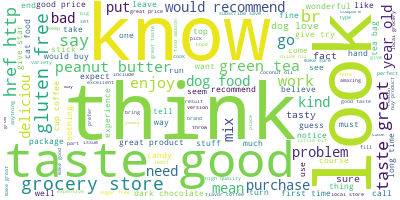

In [ ]:
#Exploratory data analysis 
# Import the wordcloud library
from nltk.corpus import stopwords
from wordcloud import WordCloud
# Join the different processed titles together.
body_string = ','.join(list(train_data['Text_processed'].values))
#using the stopwords available in python 
stopwords = set(stopwords.words("english"))
#stopwords = set(STOPWORDS)
# Create a WordCloud object
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white")
# Generate a word cloud
wordcloud.generate(body_string)
# Visualize the word cloud
wordcloud.to_image()

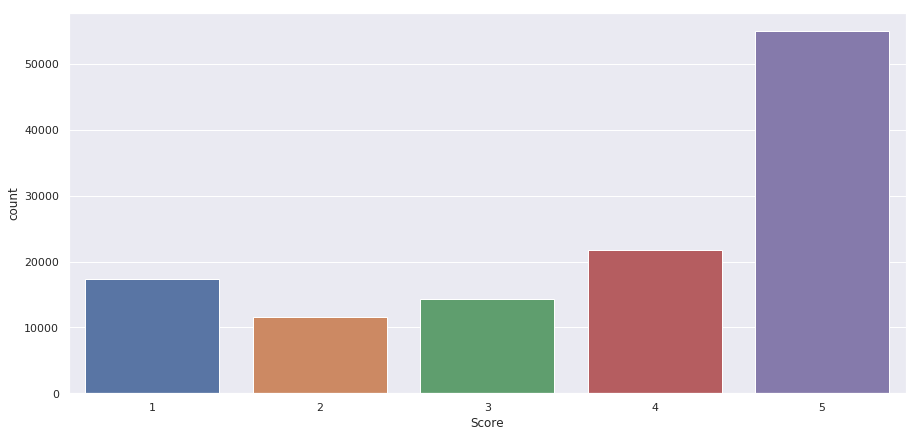

In [ ]:
import matplotlib.pyplot as plt
#Distribution of scores 
avg_scores_plot = train_data[["ProductId","Score"]].drop_duplicates()
sns.set(font_scale=1)
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax, x="Score", data=avg_scores_plot)


In [ ]:
#Top 10 most positively-rated product (with score 5) (Product ID, review_text)
temp = train_data.groupby("ProductId", as_index=False)["Score"].agg([np.mean, np.std]).sort_values("mean",ascending=False)
temp.head(10)

,mean,std
ProductId,,
B00214BO58,5.0,0.0
B002PDYN44,5.0,NaN
B002P9QAJE,5.0,0.0
B002P9QRCO,5.0,NaN
B002PA1KW0,5.0,NaN
B002PA7466,5.0,NaN
B002PAHIWQ,5.0,NaN
B002PAJFGS,5.0,NaN
B002PALD4K,5.0,0.0


In [ ]:
#Top 10 most consistent performance 
temp.sort_values("std")

,mean,std
ProductId,,
B00214BO58,5.0,0.0
B000DZL0LU,5.0,0.0
B000RI1W4I,5.0,0.0
B000RHXLXE,5.0,0.0
B000I6O3LI,5.0,0.0
...,...,...
B003EMVVP4,1.0,NaN
B005GSSI0U,1.0,NaN
B003EMVXWK,1.0,NaN


### Get Productnames for each of the product id's


In [ ]:
import requests
import pprint
from lxml import html

In [ ]:
sess = requests.Session()
sess.headers['User-Agent'] = 'Mozilla/5.0 (Windows NT 6.3; WOW64; rv:38.0) Gecko/20100101 Firefox/38.0'
ticker = "B008JV31ZS"

url = "https://www.amazon.com/dp/"+ ticker
res = sess.get(url)
data = res.content
tree = html.fromstring(data)
tree


<Element html at 0x7fd51f4b6e08>

<Response [503]>

In [ ]:
soup

<!--
        To discuss automated access to Amazon data please contact api-services-support@amazon.com.
        For information about migrating to our APIs refer to our Marketplace APIs at https://developer.amazonservices.com/ref=rm_5_sv, or our Product Advertising API at https://affiliate-program.amazon.com/gp/advertising/api/detail/main.html/ref=rm_5_ac for advertising use cases.
--><!DOCTYPE html>
<html>
<head>
<meta charset="utf-8"/>
<meta content="ie=edge" http-equiv="x-ua-compatible"/>
<meta content="width=device-width, initial-scale=1, shrink-to-fit=no" name="viewport"/>
<title>Sorry! Something went wrong!</title>
<style>
  html, body {
    padding: 0;
    margin: 0
  }

  img {
    border: 0
  }

  #a {
    background: #232f3e;
    padding: 11px 11px 11px 192px
  }

  #b {
    position: absolute;
    left: 22px;
    top: 12px
  }

  #c {
    position: relative;
    max-width: 800px;
    padding: 0 40px 0 0
  }

  #e, #f {
    height: 35px;
    border: 0;
    font-size: 1em
  }


## Modelling


In [ ]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

In [ ]:
def book_embedding_model(embedding_size = 50, classification = False):
    """Model to embed books and wikilinks using the functional API.
       Trained to discern if a link is present in a article"""
    
    # Both inputs are 1-dimensional
    book = Input(name = 'book', shape = [1])
    link = Input(name = 'link', shape = [1])
    
    # Embedding the book (shape will be (None, 1, 50))
    book_embedding = Embedding(name = 'book_embedding',
                               input_dim = len(book_index),
                               output_dim = embedding_size)(book)
    
    # Embedding the link (shape will be (None, 1, 50))
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link_index),
                               output_dim = embedding_size)(link)
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([book_embedding, link_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

# Instantiate model and show parameters
model = book_embedding_model()
model.summary()

## Generate Model

In [ ]:
n_positive = 1024

gen = generate_batch(pairs, n_positive, negative_ratio = 2)

# Train
h = model.fit_generator(gen, epochs = 15, 
                        steps_per_epoch = len(pairs) // n_positive,
                        verbose = 2)

## Extract Embedding and Analyse

In [ ]:
# Extract embeddings
book_layer = model.get_layer('book_embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape

In [ ]:
book_weights = book_weights / np.linalg.norm(book_weights, axis = 1).reshape((-1, 1))
book_weights[0][:10]
np.sum(np.square(book_weights[0]))

## Find Similar Books

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name = 'book', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link
    
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')

In [ ]:
find_similar('War and Peace', book_weights)

In [ ]:
find_similar('biography', link_weights, index_name = 'page', n = 5, plot = True)